In [1]:
import os
metrics_file = '../metrics.pkl'
metrics_file = os.path.abspath(metrics_file)
print(metrics_file)

C:\Users\kevin\PycharmProjects\701-simplicity-bias\metrics.pkl


In [2]:
import pickle
with open(metrics_file, 'rb') as in_file:
    data_dict = pickle.load(in_file)
def correct_value(val):
    # some problems with data merging
    if isinstance(val[0], list):
        x = []
        for v in val:
            x += v
        return x
    else:
        return val
data = [(eval(key), correct_value(value)) for key, value in data_dict.items()]
# del data_dict
data[0]

({'data': {'num_dim': 50,
   'margins': 0.1,
   'width': 1.0,
   'random_orthonormal_transform': True,
   'slabs': ({'count': 1, 'val': 2}, {'count': -1, 'val': 5}),
   'noise_proportions': ({'count': 1, 'val': 0.1}, {'count': -1, 'val': 0}),
   'slab_probabilities': ({'count': 1, 'val': (1.0, 1.0)},
    {'count': -1, 'val': (0.015625, 0.5, 0.96875, 0.5, 0.015625)}),
   'train_samples': 50000,
   'val_samples': 10000,
   'simple_axes': (0,),
   'batch_size': 256},
  'model': {'cls': 'fcn',
   'num_layers': 2,
   'input_dim': 50,
   'output_dim': 2,
   'latent_dim': 300,
   'use_bn': False,
   'dropout_probability': 0.0,
   'linear_init': None,
   'loss': 'CrossEntropy'},
  'optimizer': {'cls': 'SGD',
   'lr': 0.3,
   'weight_decay': 0.0005,
   'momentum': 0.0},
  'scheduler': {'cls': 'None'},
  'trainer': {'premature_evaluate_interval': 1000,
   'evaluate_interval': 5000,
   'save_interval': 0,
   'accuracy_threshold': 0.995,
   'max_steps': 250000},
  'seed': 80},
 [{'Train/AUC': 1.0,

In [3]:
def flatten_dict(dd, separator ='_', prefix =''):
    # https://www.geeksforgeeks.org/python-convert-nested-dictionary-into-flattened-dictionary/
    return { prefix + separator + k if prefix else k : v
             for kk, vv in dd.items()
             for k, v in flatten_dict(vv, separator, kk).items()
             } if isinstance(dd, dict) else { prefix : dd }
def show_diff(dict1, dict2, ignored_keys=('trainer_max_steps', 'seed')):
    dict1 = flatten_dict(dict1)
    dict2 = flatten_dict(dict2)
    diff_dict = {}
    for k, v in dict1.items():
        if k in ignored_keys:
            continue
        if k not in dict2 or dict2[k] != dict1[k]:
            diff_dict[k] = dict2[k] if k in dict2 else None
    for k, v in dict2.items():
        if k in ignored_keys:
            continue
        if k not in dict1:
            diff_dict[k] = dict2[k]
    return diff_dict
import sys
sys.path.append(os.path.abspath('..'))
from configs import lms_7_fcn300_2, lms_5_fcn300_2

In [17]:
data_tuning = [(key, val) for key, val in data if key['data']['train_samples'] == 200000]
# [show_diff(lms_7_fcn300_2, key) for key, val in data_tuning]

In [18]:
data_tuning_dict = {}
for key, val in data_tuning:
    tuning_param = key['model']['latent_dim'], key['model']['num_layers'], key['optimizer']['lr'], key['optimizer']['momentum']
    if tuning_param in data_tuning_dict:
        data_tuning_dict[tuning_param].extend(val)
    else:
        data_tuning_dict[tuning_param] = val
with open('hyperparam_tuning.csv', 'wt') as out_f:
    print('Latent Dim,Layers,LR,Momentum,TrainAcc,ValAcc', sep=',', file=out_f)
    for key, values in data_tuning_dict.items():
        print(*key, 
              sum([float(v['Train/Accuracy']) for v in values]) / len(values),
              sum([float(v['Val/Accuracy']) for v in values]) / len(values),
              sep=',', file=out_f)

In [19]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

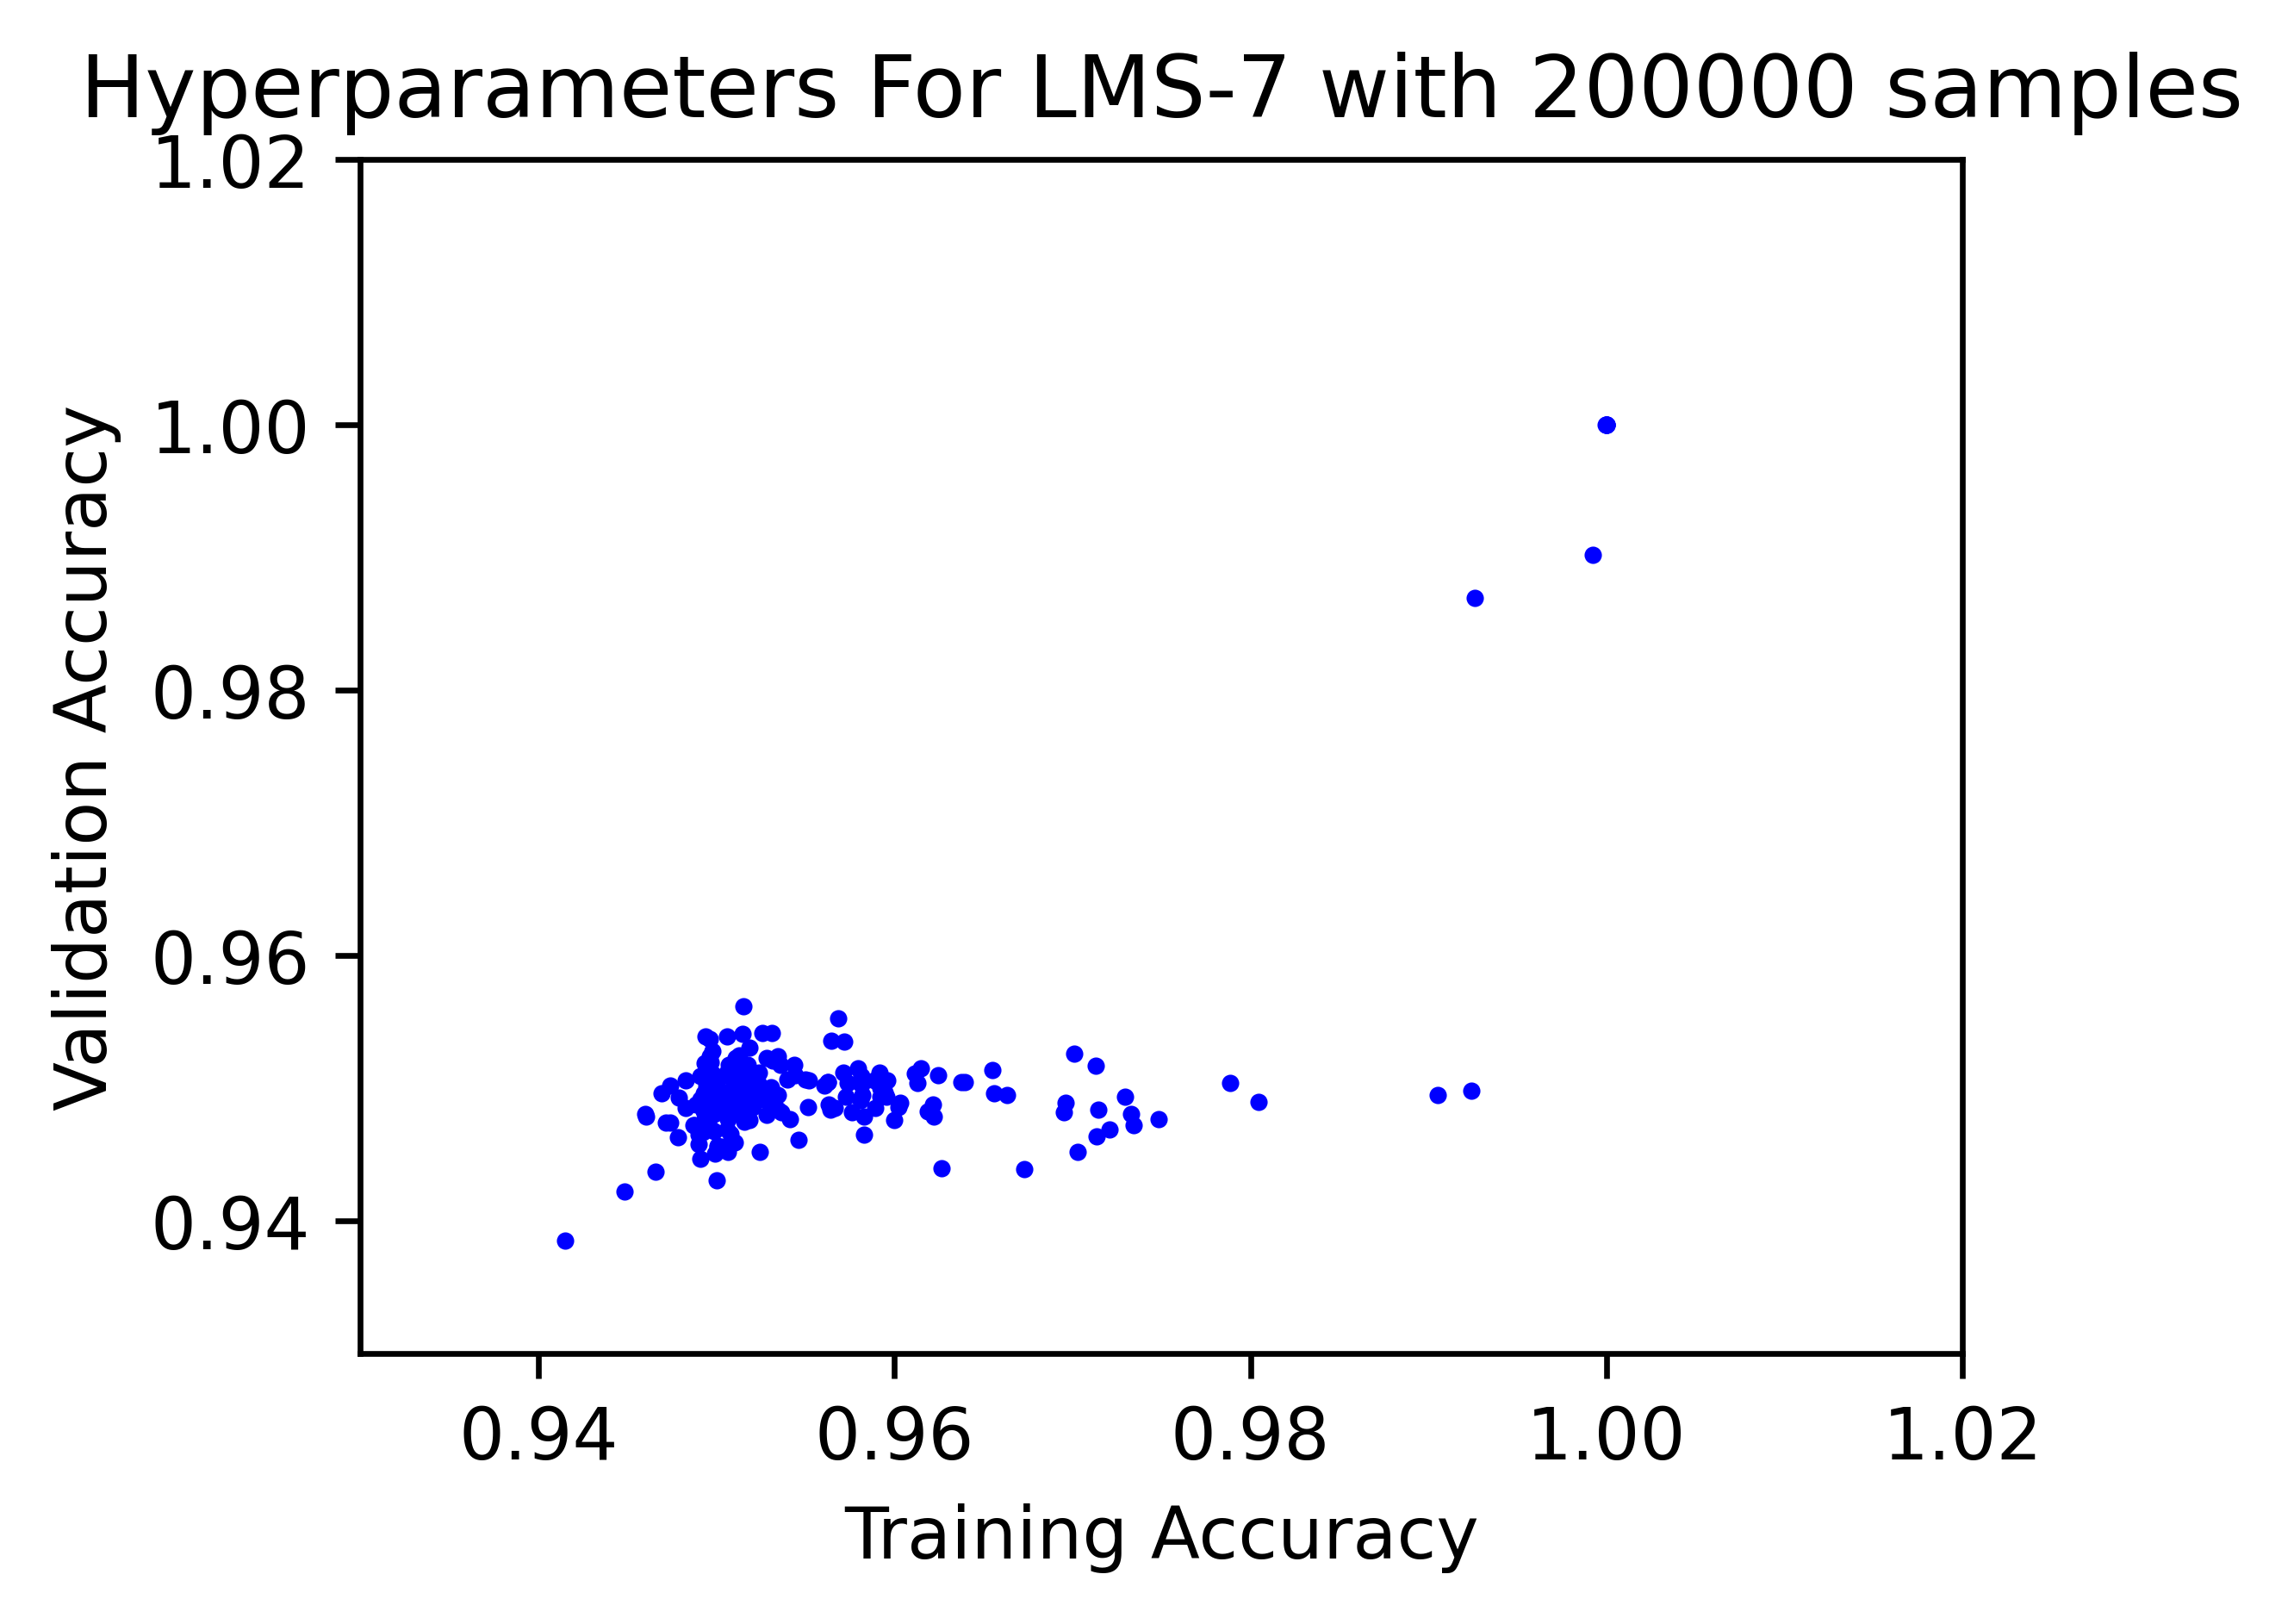

In [8]:
fig = plt.figure(figsize=(4, 3), dpi=600)
for values in data_tuning_dict.values():
    for v in values:
        plt.scatter(v['Train/Accuracy'], v['Val/Accuracy'], s=2, color='blue')
plt.xlim([0.93, 1.02])
plt.ylim([0.93, 1.02])
plt.xlabel('Training Accuracy')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameters For LMS-7 with 200000 samples')
plt.savefig('hyperparams_200000.png', dpi=600, pad_inches=0, bbox_inches='tight')
plt.show()
plt.close(fig)

In [25]:
def filter_nsamples(key):
    return (
        ('activation' not in key['model'] or key['model']['activation'] == 'ReLU') and
        key['optimizer']['lr'] == 0.3 and
        key['optimizer']['momentum'] == 0.0 and
        key['model']['latent_dim'] == 300 and
        key['model']['num_layers'] == 2 and
        key['data']['slab_probabilities'] == lms_7_fcn300_2['data']['slab_probabilities'] and
        key['data']['num_dim'] == lms_7_fcn300_2['data']['num_dim'] and
        key['data']['noise_proportions'] == lms_7_fcn300_2['data']['noise_proportions']
    )

data_nsamples = [(key, val) for key, val in data if filter_nsamples(key)]
# [show_diff(lms_7_fcn300_2, key) for key, val in data_nsamples]

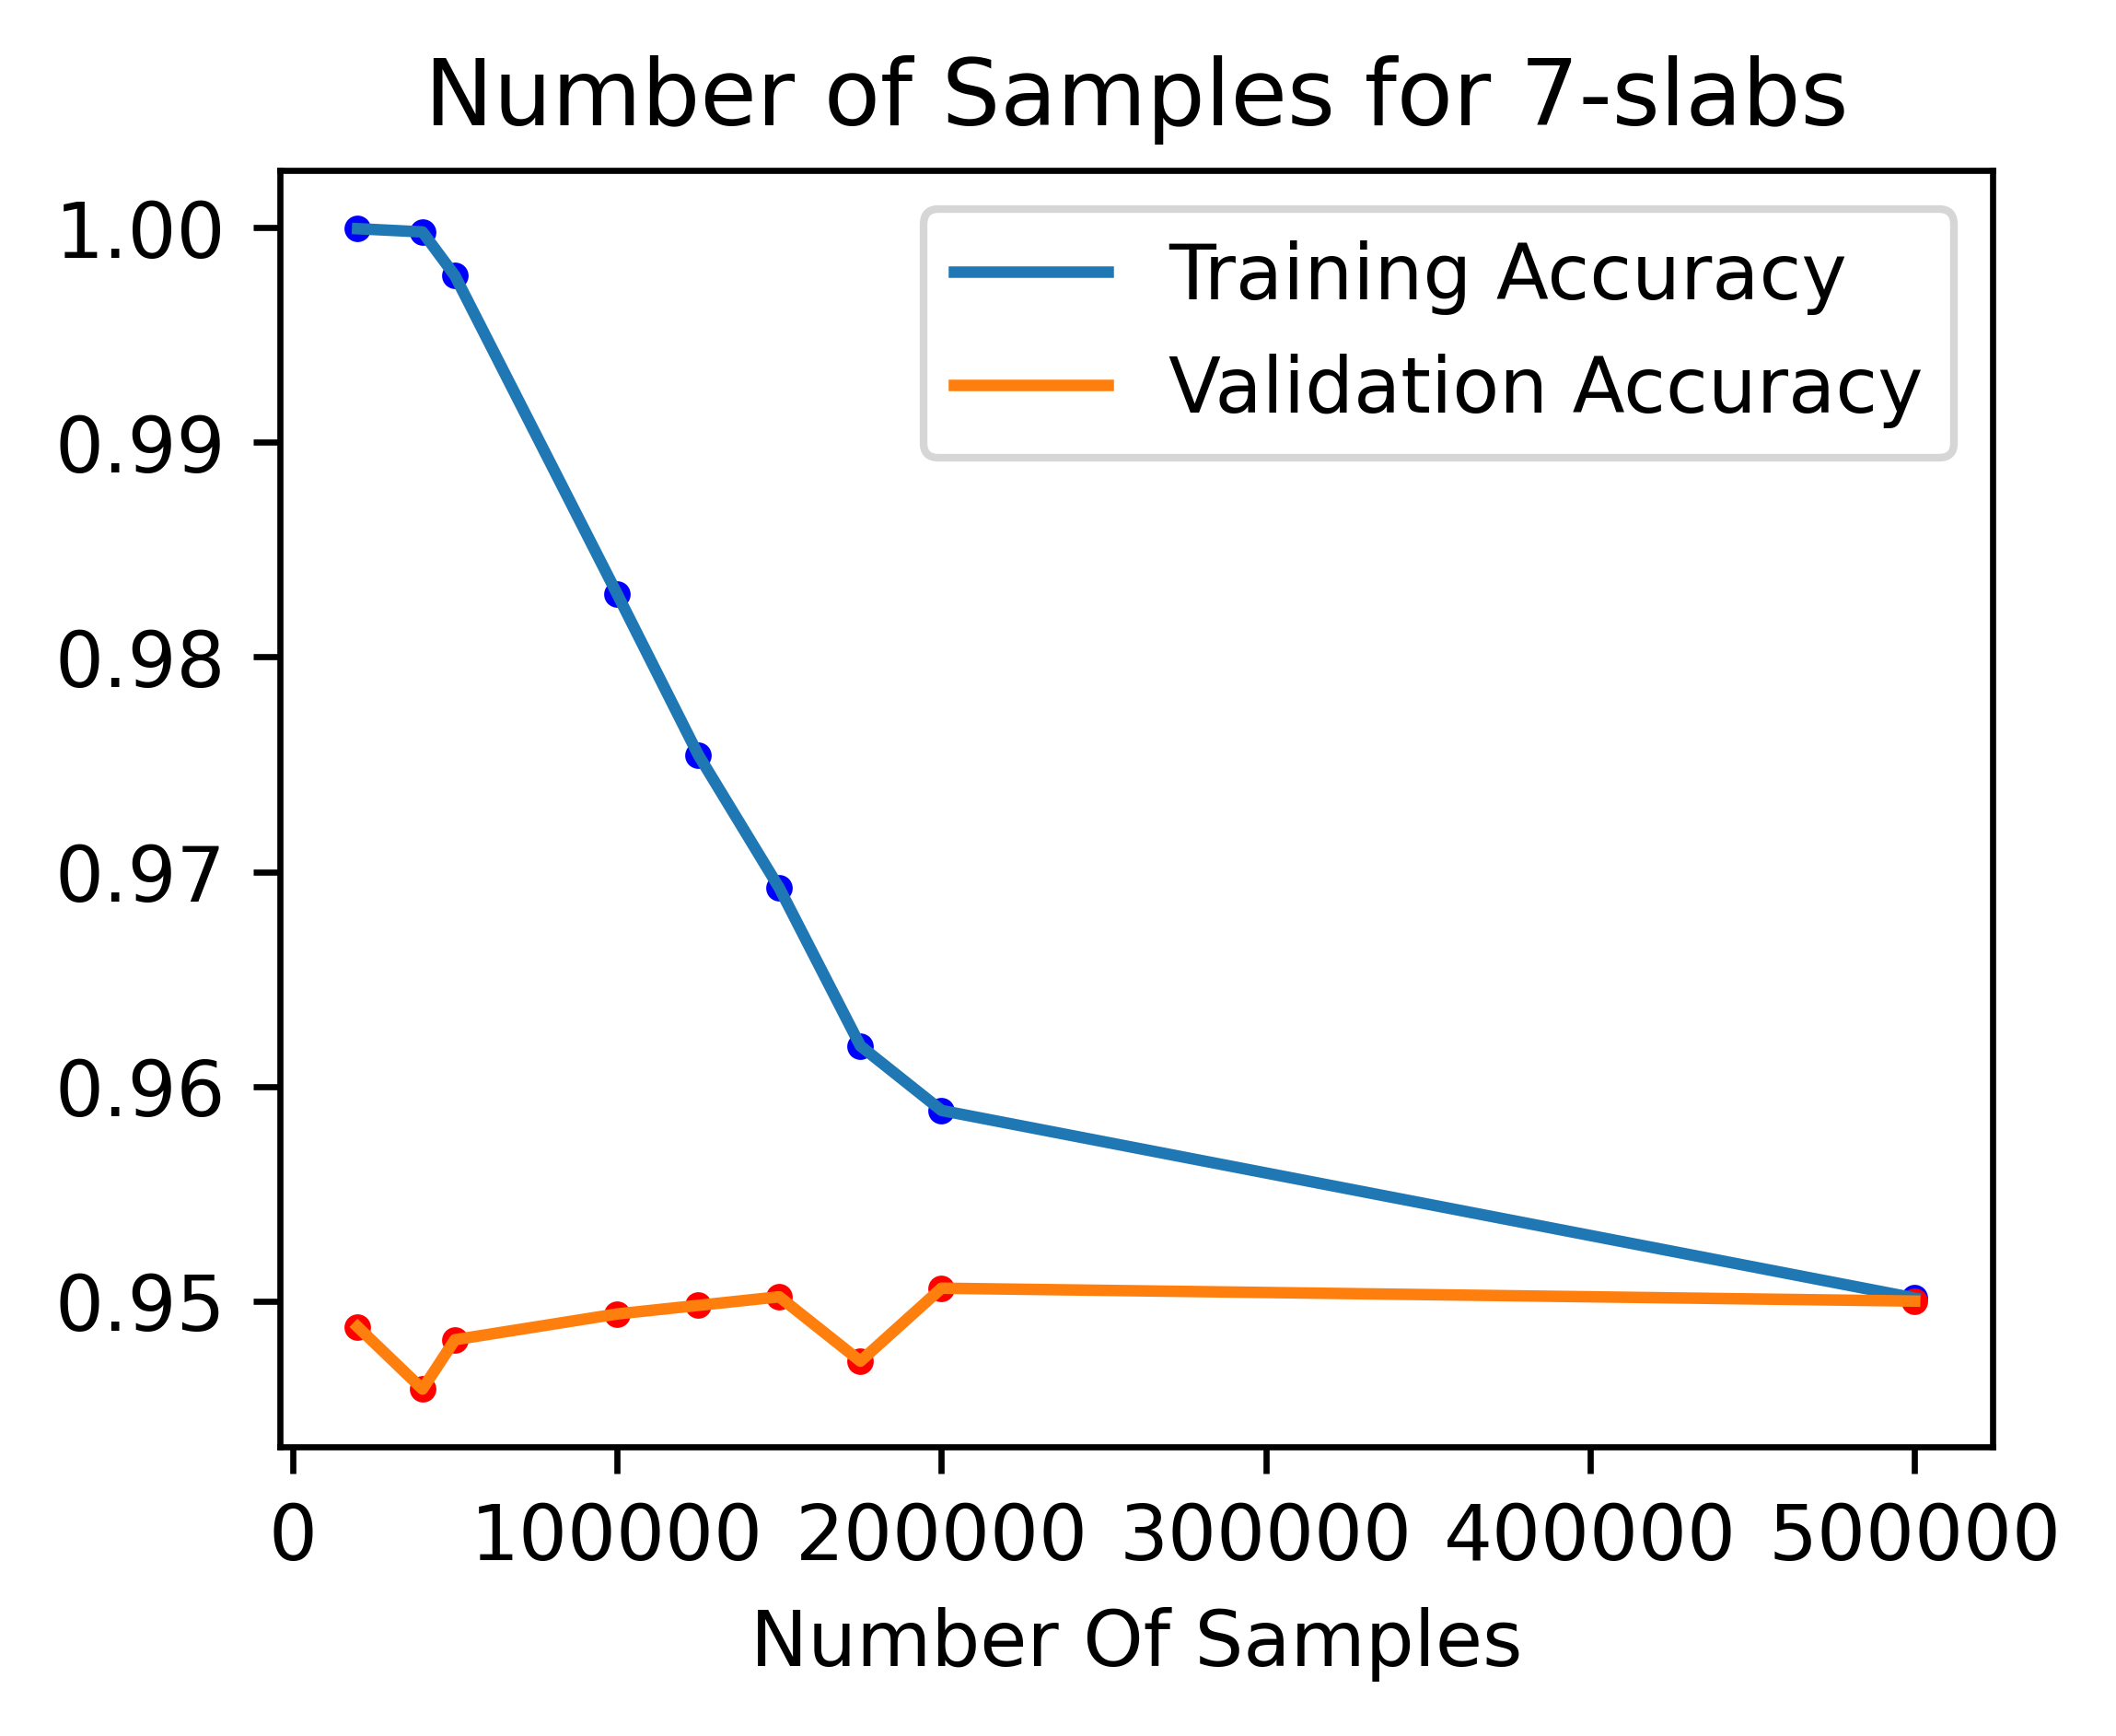

In [46]:
data_nsamples_dict = {}
nsamples_keys = []
for key, val in data_nsamples:
    nsamples = key['data']['train_samples']
    if False and nsamples in data_nsamples_dict: # need to remove outliers, fix it later
        data_nsamples_dict[nsamples].extend(val)
    else:
        data_nsamples_dict[nsamples] = val
        nsamples_keys.append(nsamples)
def avg(lst):
    return sum(lst) / len(lst)
fig = plt.figure(figsize=(4, 3), dpi=600)
nsamples_keys.sort()
train_accs = [avg([v['Train/Accuracy'] for v in data_nsamples_dict[key]]) for key in nsamples_keys]
val_accs = [avg([v['Val/Accuracy'] for v in data_nsamples_dict[key]]) for key in nsamples_keys]
plt.plot(nsamples_keys, train_accs, label='Training Accuracy')
plt.plot(nsamples_keys, val_accs, label='Validation Accuracy')
for key, val in data_nsamples_dict.items():
    for v in val:
        plt.scatter(key, v['Train/Accuracy'], color='blue', s=6)
        plt.scatter(key, v['Val/Accuracy'], color='red', s=6)
plt.title('Number of Samples for 7-slabs')
plt.savefig('7slabs_nsamples.pdf', dpi=600, pad_inches=0, bbox_inches='tight')
plt.xlabel('Number Of Samples')
plt.legend()
plt.show()
plt.close(fig)

In [47]:
data_tanh_7slabs = [(key, val) for key, val in data if 'activation' in key['model'] and key['model']['activation'] == 'tanh' and
                                                        key['data']['slabs'][1]['val'] == 7]
# [show_diff(lms_7_fcn300_2, key, ignored_keys=('trainer_max_steps', 'seed', 'model_activation')) for key, val in data_tanh]

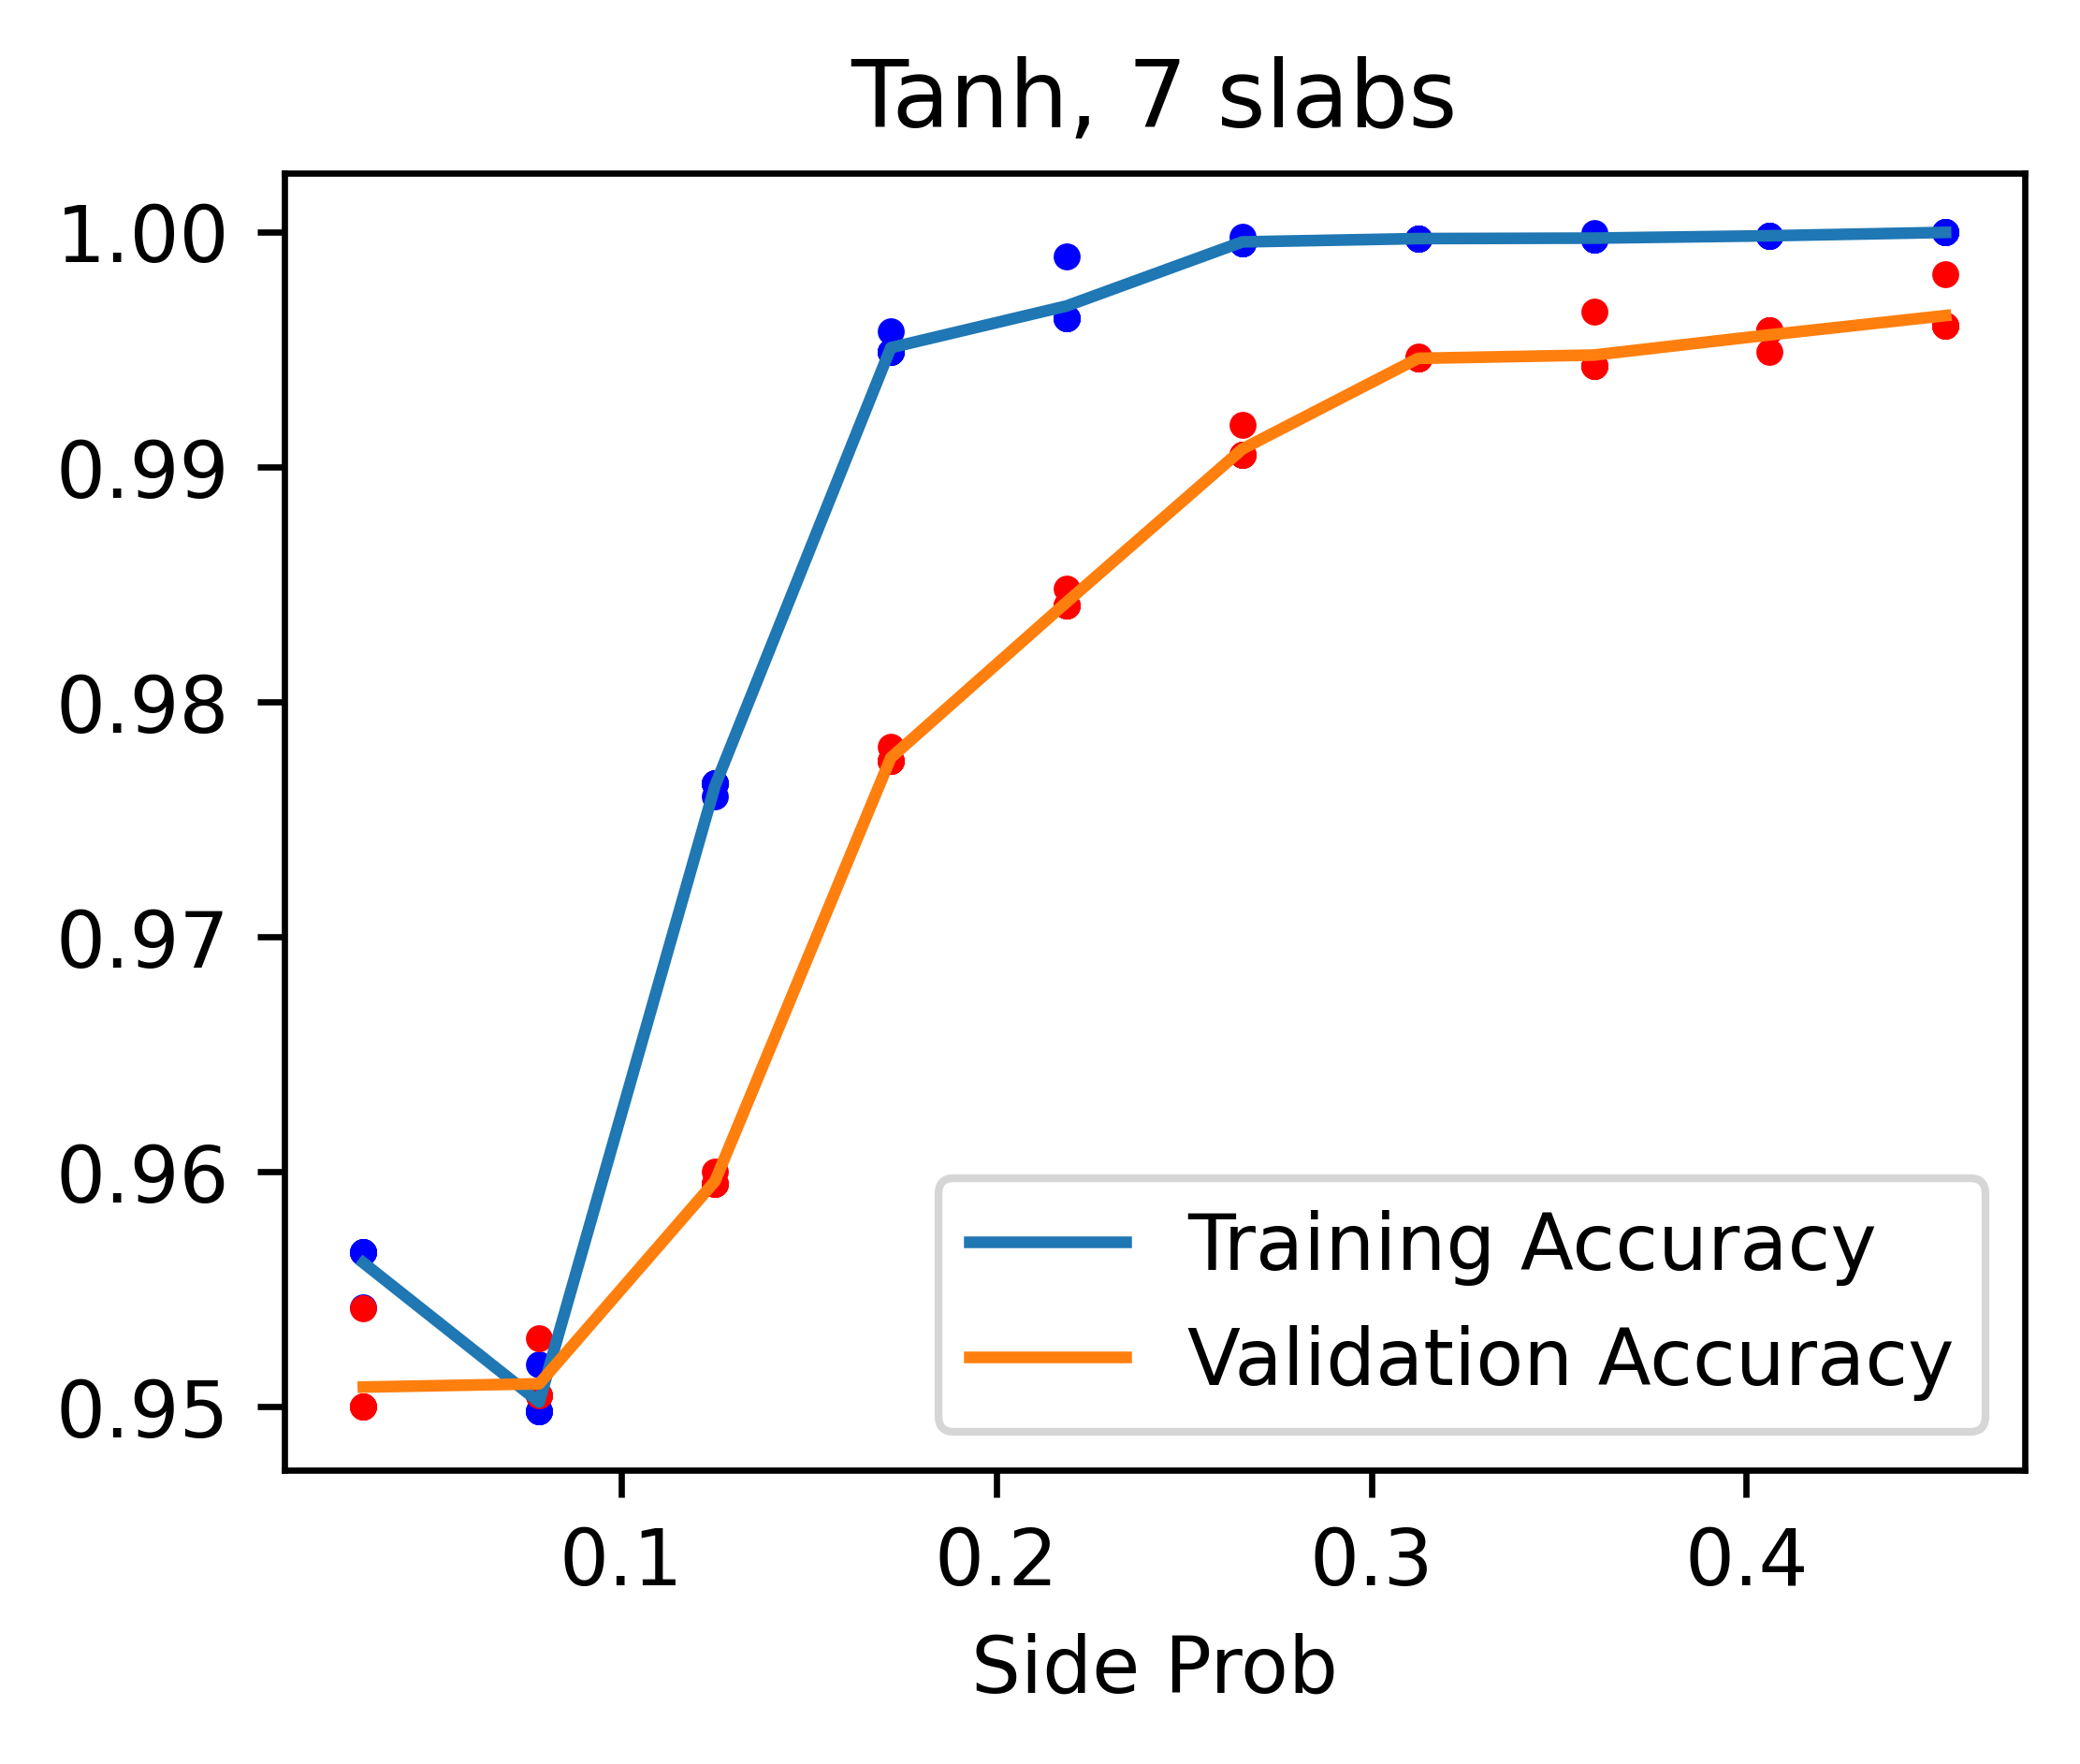

In [51]:
data_tanh_sideprob_dict = {}
sideprob_keys = []
for key, val in data_tanh_7slabs:
    nsamples = key['data']['slab_probabilities'][1]['val'][0]
    if nsamples in data_tanh_sideprob_dict:
        data_tanh_sideprob_dict[nsamples].extend(val)
    else:
        data_tanh_sideprob_dict[nsamples] = val
        sideprob_keys.append(nsamples)
def avg(lst):
    return sum(lst) / len(lst)
fig = plt.figure(figsize=(4, 3), dpi=600)
sideprob_keys.sort()
train_accs = [avg([v['Train/Accuracy'] for v in data_tanh_sideprob_dict[key]]) for key in sideprob_keys]
val_accs = [avg([v['Val/Accuracy'] for v in data_tanh_sideprob_dict[key]]) for key in sideprob_keys]
plt.plot(sideprob_keys, train_accs, label='Training Accuracy')
plt.plot(sideprob_keys, val_accs, label='Validation Accuracy')
for key, val in data_tanh_sideprob_dict.items():
    for v in val:
        plt.scatter(key, v['Train/Accuracy'], color='blue', s=6)
        plt.scatter(key, v['Val/Accuracy'], color='red', s=6)
plt.title('Tanh, 7 slabs')
plt.savefig('7slabs_tanh_sideprob.pdf', dpi=600, pad_inches=0, bbox_inches='tight')
plt.xlabel('Side Prob')
plt.legend()
plt.show()
plt.close(fig)

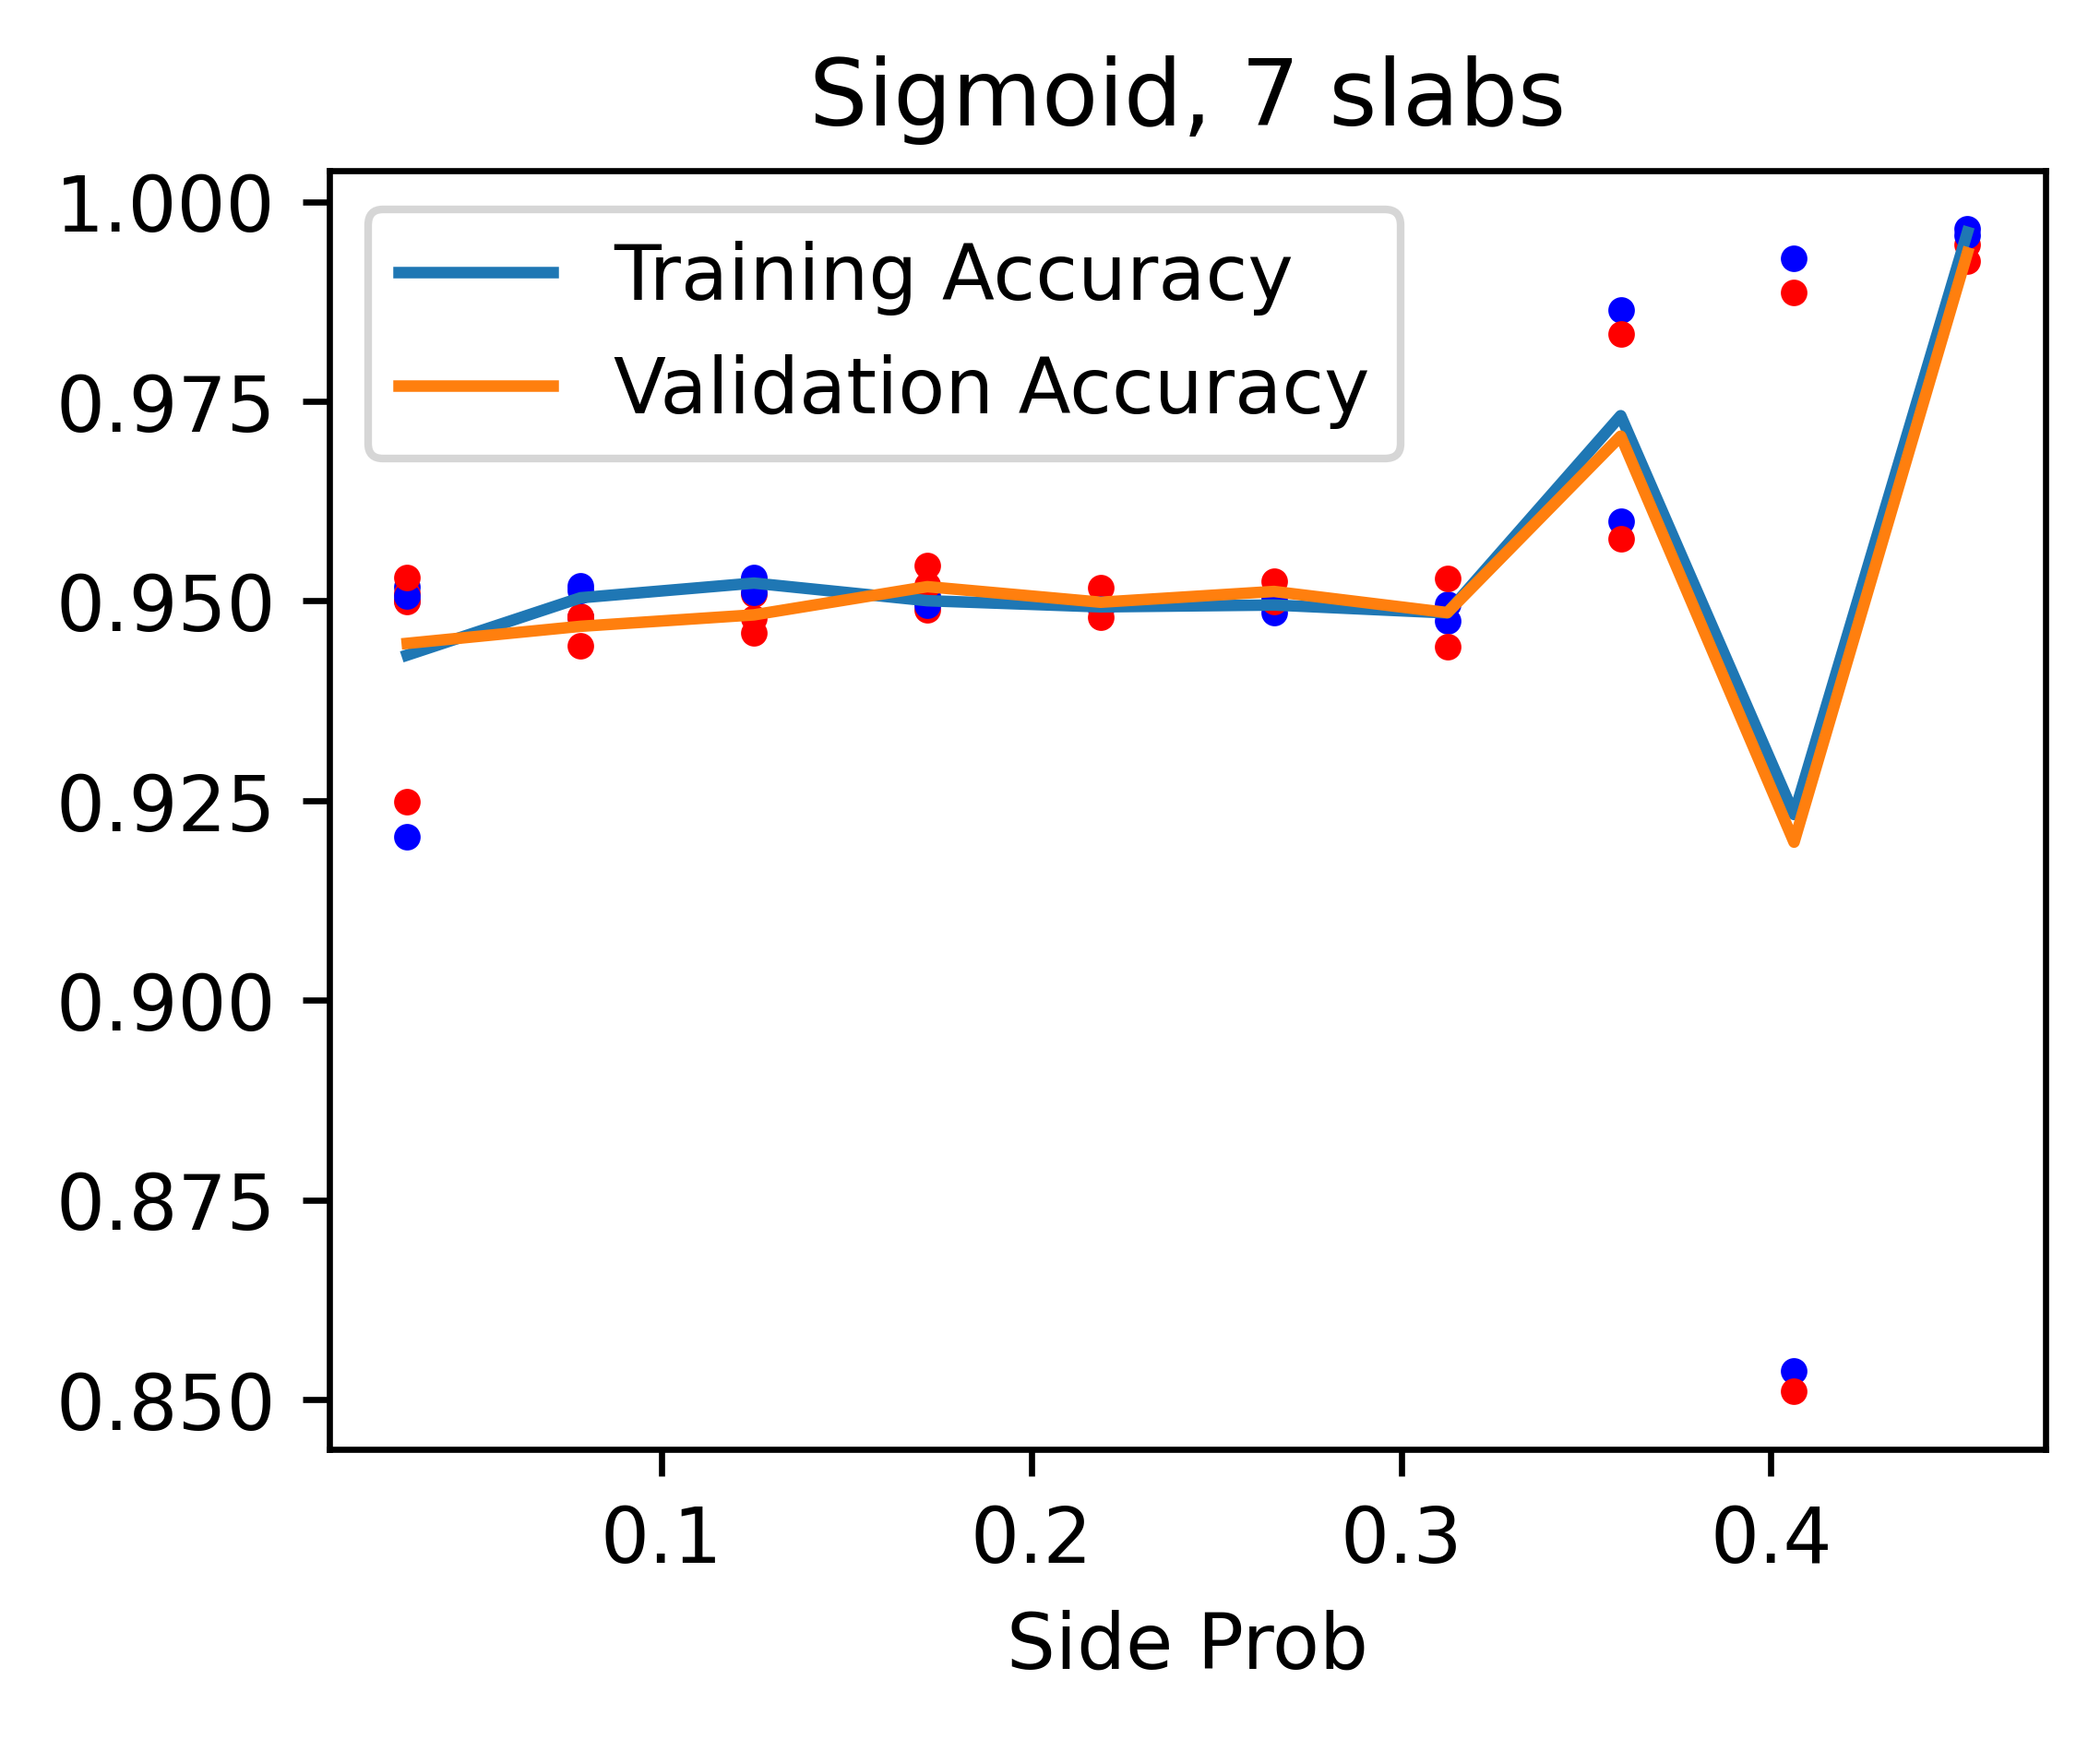

In [52]:
data_tanh_7slabs = [(key, val) for key, val in data if 'activation' in key['model'] and key['model']['activation'] == 'sigmoid' and
                                                        key['data']['slabs'][1]['val'] == 7]
data_tanh_sideprob_dict = {}
sideprob_keys = []
for key, val in data_tanh_7slabs:
    nsamples = key['data']['slab_probabilities'][1]['val'][0]
    if nsamples in data_tanh_sideprob_dict:
        data_tanh_sideprob_dict[nsamples].extend(val)
    else:
        data_tanh_sideprob_dict[nsamples] = val
        sideprob_keys.append(nsamples)
def avg(lst):
    return sum(lst) / len(lst)
fig = plt.figure(figsize=(4, 3), dpi=600)
sideprob_keys.sort()
train_accs = [avg([v['Train/Accuracy'] for v in data_tanh_sideprob_dict[key]]) for key in sideprob_keys]
val_accs = [avg([v['Val/Accuracy'] for v in data_tanh_sideprob_dict[key]]) for key in sideprob_keys]
plt.plot(sideprob_keys, train_accs, label='Training Accuracy')
plt.plot(sideprob_keys, val_accs, label='Validation Accuracy')
for key, val in data_tanh_sideprob_dict.items():
    for v in val:
        plt.scatter(key, v['Train/Accuracy'], color='blue', s=6)
        plt.scatter(key, v['Val/Accuracy'], color='red', s=6)
plt.title('Sigmoid, 7 slabs')
plt.savefig('7slabs_sigmoid_sideprob.pdf', dpi=600, pad_inches=0, bbox_inches='tight')
plt.xlabel('Side Prob')
plt.legend()
plt.show()
plt.close(fig)